# Load packages


In [1]:
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage.filters import gaussian
from skimage.measure import label, regionprops, regionprops_table

# Read data


In [2]:
data_path = "cwk-data/data/BOARDS/"

In [3]:
board_2 = cv2.imread(f"{data_path}BOARD2-1.jpg")
board_3 = cv2.imread(f"{data_path}BOARD3-1.jpg")

Convert images from `BGR` to `RGB`:


In [4]:
board_2 = cv2.cvtColor(board_2, cv2.COLOR_BGR2RGB)
board_3 = cv2.cvtColor(board_3, cv2.COLOR_BGR2RGB)

Create grayscale images:


In [5]:
board_2_gray = cv2.cvtColor(board_2, cv2.COLOR_RGB2GRAY)
board_3_gray = cv2.cvtColor(board_3, cv2.COLOR_RGB2GRAY)

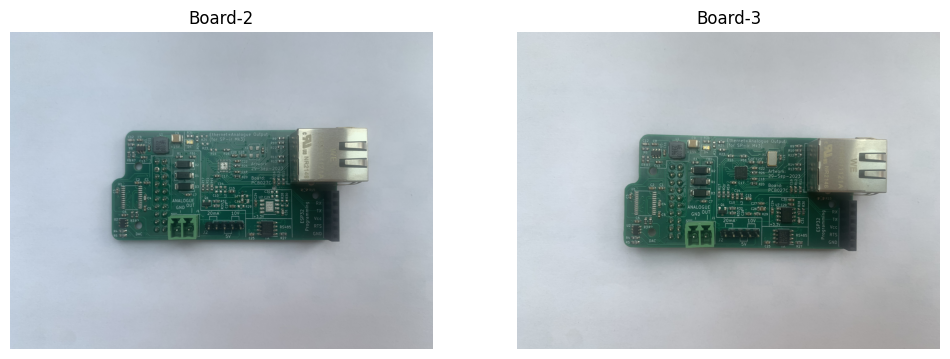

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(board_2)
ax[0].axis("off")
ax[0].set_title("Board-2")

ax[1].imshow(board_3)
ax[1].axis("off")
ax[1].set_title("Board-3")

plt.show()

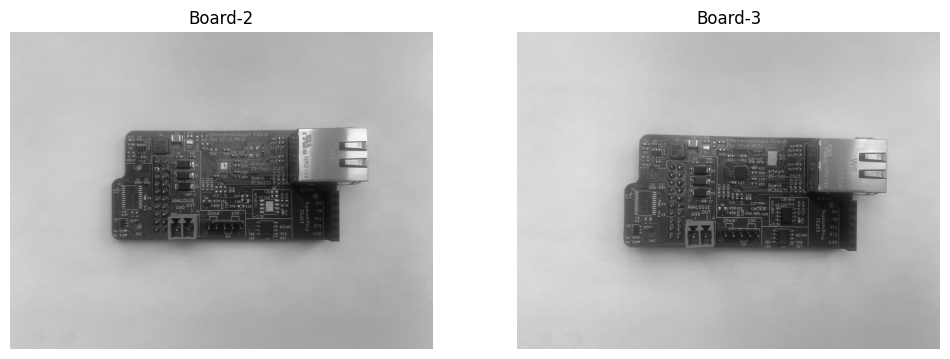

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(board_2_gray, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Board-2")

ax[1].imshow(board_3_gray, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Board-3")

plt.show()

# SIFT Feature Extraction


In [8]:
sift = cv2.SIFT_create()

In [9]:
board_2_kp, board_2_des = sift.detectAndCompute(board_2_gray, None)
board_3_kp, board_3_des = sift.detectAndCompute(board_3_gray, None)

# Feature Matching using `FlannBasedMatcher`


In [10]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

In [11]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [12]:
# find two nearest matches (k=2)
matches = flann.knnMatch(board_2_des, board_3_des, k=2)

In [13]:
len(matches)

11466

Prune matches using Lowe's ratio test:


In [14]:
# store all the good matches as per Lowe's ratio test.
matchesMask = [[0, 0] for i in range(len(matches))]
good_matches = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)
        matchesMask[i] = [1, 0]

In [15]:
len(good_matches)

924

Draw SIFT matches between `board-2` and `board-3`:


Text(0.5, 1.0, 'SIFT matches between Board-2 and Board-3')

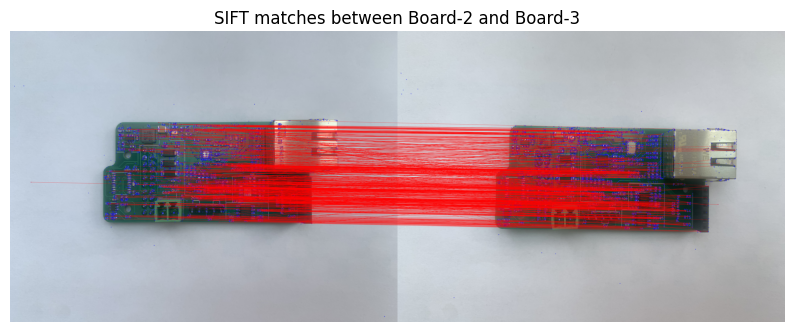

In [16]:
draw_params = dict(
    matchColor=(255, 0, 0),
    singlePointColor=(0, 0, 255),
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_DEFAULT,
)

img3 = cv2.drawMatchesKnn(
    board_2, board_2_kp, board_3, board_3_kp, matches, None, **draw_params
)

fig = plt.figure(figsize=(10, 8))

plt.imshow(img3)
plt.axis("off")
plt.title("SIFT matches between Board-2 and Board-3")

# Homography matrix


Get the matching SIFT key points from both images:


In [17]:
# get the indicies of the matching key points
src_points_idx = [match.queryIdx for match in good_matches]
dst_points_idx = [match.trainIdx for match in good_matches]

In [18]:
# get the corresponding SIFT key points from each image

src_points = np.float32(
    [board_2_kp[point_idx].pt for point_idx in src_points_idx]
).reshape(-1, 1, 2)

dst_points = np.float32(
    [board_3_kp[point_idx].pt for point_idx in dst_points_idx]
).reshape(-1, 1, 2)

Find the homography transformation matrix using RANSAC algorithm:


In [19]:
M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

In [20]:
M.shape

(3, 3)

In [21]:
mask.shape

(924, 1)

In [22]:
sum(mask)

array([133], dtype=uint8)

# Image Alignment


Using the perspective matrix, we can align `Board-2` to the `Board-3`'s perspective.


In [23]:
board_2_aligned = cv2.warpPerspective(board_2, M, (board_3.shape[1], board_3.shape[0]))

(-0.5, 4031.5, 3023.5, -0.5)

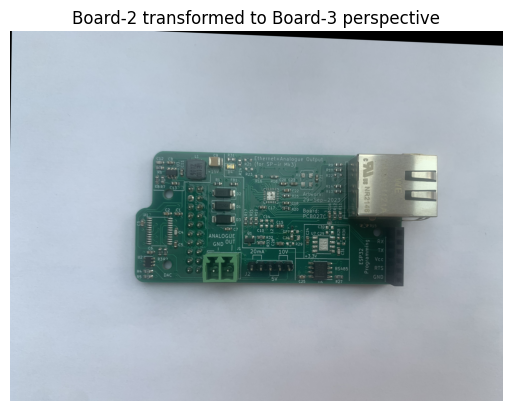

In [24]:
plt.imshow(board_2_aligned)
plt.title("Board-2 transformed to Board-3 perspective")
plt.axis("off")

(-0.5, 4031.5, 3023.5, -0.5)

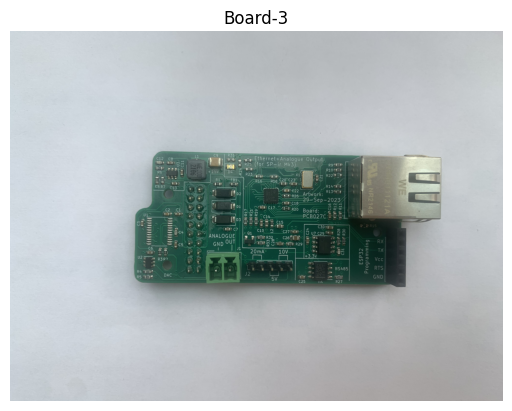

In [25]:
plt.imshow(board_3)
plt.title("Board-3")
plt.axis("off")

# Blending Board-2 and Board-3


Now that the two boards are aligned, we can blend them together. We use the `addWeighted` function which produces the weighted sum of two images.

Here, we selectl alpha=0.6. 1 - alpha is multipled by the first image and alpha is multiplied by the seconds image.

A value of 0.6 means we take almost equal amout of the two images but we weight the second image higher.


In [26]:
alpha = 0.6
blended_image = cv2.addWeighted(board_3, 1 - alpha, board_2_aligned, alpha, 0)

(-0.5, 4031.5, 3023.5, -0.5)

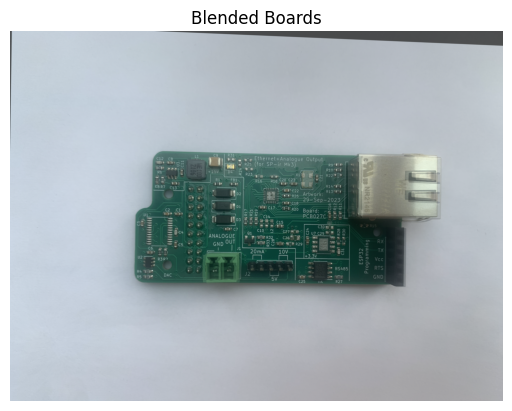

In [27]:
plt.imshow(blended_image)
plt.title("Blended Boards")
plt.axis("off")

# Finding difference


For finding the difference, we will calculate the absolute difference between the original image (board_3) and board after alignment.


In [28]:
# taking difference in RGB space

diff_1 = cv2.absdiff(board_3, blended_image)
diff_2 = cv2.absdiff(board_3, board_2_aligned)

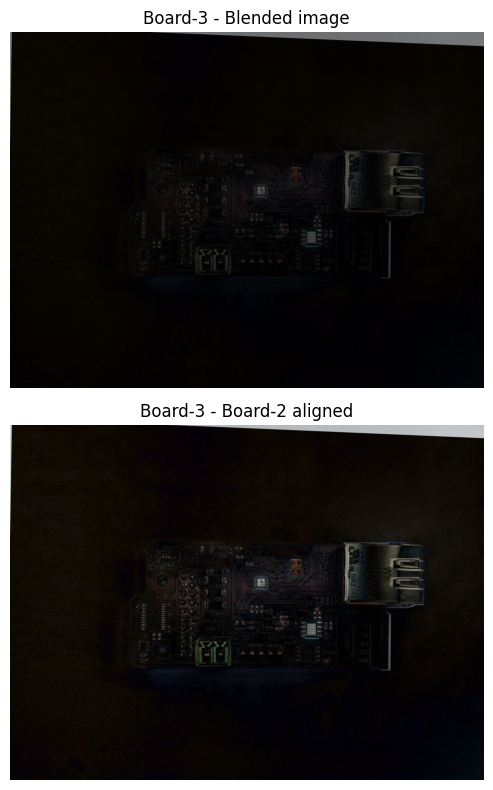

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].imshow(diff_1)
ax[0].axis("off")
ax[0].set_title("Board-3 - Blended image")

ax[1].imshow(diff_2)
ax[1].axis("off")
ax[1].set_title("Board-3 - Board-2 aligned")

plt.tight_layout()
plt.show()

In [30]:
# taking difference in grayscale

diff_1 = cv2.absdiff(
    cv2.cvtColor(board_3, cv2.COLOR_RGB2GRAY),
    cv2.cvtColor(blended_image, cv2.COLOR_RGB2GRAY),
)

diff_2 = cv2.absdiff(
    cv2.cvtColor(board_3, cv2.COLOR_RGB2GRAY),
    cv2.cvtColor(board_2_aligned, cv2.COLOR_RGB2GRAY),
)

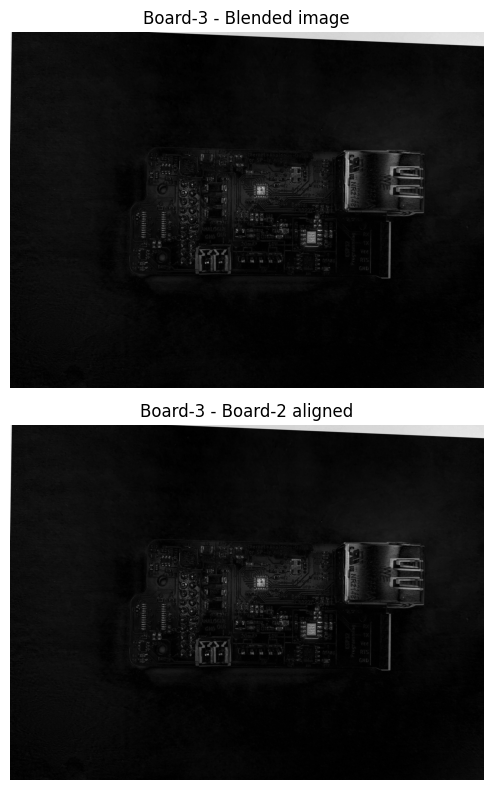

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].imshow(diff_1, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Board-3 - Blended image")

ax[1].imshow(diff_2, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Board-3 - Board-2 aligned")

plt.tight_layout()
plt.show()

We can how this difference highlights the difference between the boards: board-2 and board-3.

To accurately identify the location of difference, we extract the regions from the above binary image.


Threshold the the difference image at value 20 to get a binary image


In [32]:
_, thresholded_img = cv2.threshold(diff_1, 20, 255, cv2.THRESH_BINARY)

(-0.5, 4031.5, 3023.5, -0.5)

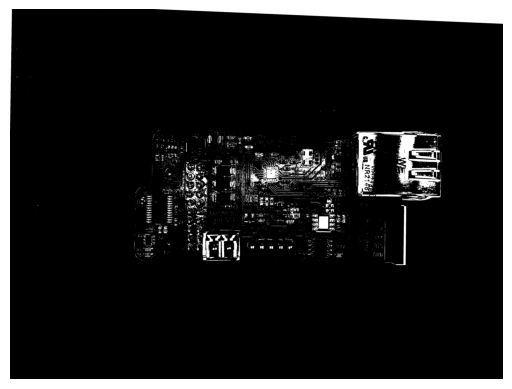

In [33]:
plt.imshow(thresholded_img, cmap="gray")
plt.axis("off")

In [34]:
comps = label(gaussian(thresholded_img))

In [35]:
print(np.unique(comps))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


In [36]:
regions = regionprops(comps)

In [37]:
pd.DataFrame(regionprops_table(comps, properties=["label", "area"])).sort_values(
    by="area", ascending=False
).head(10)

,label,area
1,2,161544.0
8,9,23489.0
12,13,21948.0
156,157,6245.0
0,1,4587.0
141,142,4492.0
83,84,3355.0
56,57,3110.0
169,170,2404.0
31,32,1937.0


In [38]:
filtered_props = [region for region in regions if int(region.area) > 1000]

(-0.5, 4031.5, 3023.5, -0.5)

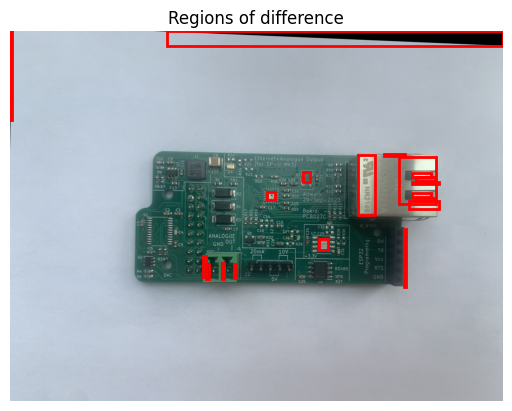

In [39]:
fig, ax = plt.subplots()

ax.imshow(board_2_aligned)

for region in filtered_props:
    minr, minc, maxr, maxc = region.bbox

    rect = plt.Rectangle(
        (minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor="red", linewidth=2
    )

    ax.add_patch(rect)

plt.title("Regions of difference")
plt.axis("off")

We can see that the three chips have been detected. However, non-difference regions were also detected.

To imporve this, we can first crop the image to the board only.
